<a href="https://colab.research.google.com/github/PimiYvan/proto_adaptation/blob/main/tent_proto_meta_dataset_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Meta-Dataset Data Pipeline

This notebook shows how to use `meta_dataset`’s input pipeline to sample data for the Meta-Dataset benchmark. There are two main ways in which data is sampled:
1. **episodic**:  Returns N-way classification *episodes*, which contain a *support* (training) set and a *query* (test) set. The number of classes (N) may vary from episode to episode.
2. **batch**:  Returns batches of images and their corresponding label, sampled from all available classes.

We first import `meta_dataset` and other required packages, and define utility functions for visualization. We’ll make use of `meta_dataset.data.learning_spec` and `meta_dataset.data.pipeline`; their purpose will be made clear later on.

In [ ]:
!git clone https://github.com/google-research/meta-dataset.git
!cp -r "/content/meta-dataset/meta_dataset" "/content/"
!cd meta-dataset/ && python3 setup.py install

Cloning into 'meta-dataset'...
remote: Enumerating objects: 3060, done.
remote: Counting objects: 100% (830/830), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 3060 (delta 729), reused 720 (delta 703), pack-reused 2230
Receiving objects: 100% (3060/3060), 3.32 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (2305/2305), done.
running install
running simclr_download
running build
running build_py
creating build/lib/meta_dataset
copying meta_dataset/analyze.py -> build/lib/meta_dataset
copying meta_dataset/train_flute.py -> build/lib/meta_dataset
copying meta_dataset/__init__.py -> build/lib/meta_dataset
copying meta_dataset/trainer.py -> build/lib/meta_dataset
copying meta_dataset/distribute_utils.py -> build/lib/meta_dataset
copying meta_dataset/test_utils.py -> build/lib/meta_dataset
copying meta_dataset/train.py -> build/lib/meta_dataset
copying meta_dataset/trainer_test.py -> build/lib/meta_dataset
copying meta_dataset/trainer_flute.py -> build/lib/meta_data

Imports and Utility Functions

In [ ]:
#@title Imports and Utility Functions
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from collections import Counter
import gin
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from meta_dataset.data import config
from meta_dataset.data import dataset_spec as dataset_spec_lib
from meta_dataset.data import learning_spec
from meta_dataset.data import pipeline
import matplotlib.pyplot as plt
import torch

def plot_episode(support_images, support_class_ids, query_images,
                 query_class_ids, size_multiplier=1, max_imgs_per_col=10,
                 max_imgs_per_row=10):
  for name, images, class_ids in zip(('Support', 'Query'),
                                     (support_images, query_images),
                                     (support_class_ids, query_class_ids)):
    n_samples_per_class = Counter(class_ids)
    n_samples_per_class = {k: min(v, max_imgs_per_col)
                           for k, v in n_samples_per_class.items()}
    id_plot_index_map = {k: i for i, k
                         in enumerate(n_samples_per_class.keys())}
    num_classes = min(max_imgs_per_row, len(n_samples_per_class.keys()))
    max_n_sample = max(n_samples_per_class.values())
    figwidth = max_n_sample
    figheight = num_classes
    
    if name == 'Support':
      print('#Classes: %d' % len(n_samples_per_class.keys()))
    figsize = (figheight * size_multiplier, figwidth * size_multiplier)
    fig, axarr = plt.subplots(
        figwidth, figheight, figsize=figsize)
    fig.suptitle('%s Set' % name, size='20')
    fig.tight_layout(pad=3, w_pad=0.1, h_pad=0.1)
    reverse_id_map = {v: k for k, v in id_plot_index_map.items()}
    for i, ax in enumerate(axarr.flat):
      ax.patch.set_alpha(0)
      # Print the class ids, this is needed since, we want to set the x axis
      # even there is no picture.
      ax.set(xlabel=reverse_id_map[i % figheight], xticks=[], yticks=[])
      ax.label_outer()
    for image, class_id in zip(images, class_ids):
      # First decrement by one to find last spot for the class id.
      n_samples_per_class[class_id] -= 1
      # If class column is filled or not represented: pass.
      if (n_samples_per_class[class_id] < 0 or
          id_plot_index_map[class_id] >= max_imgs_per_row):
        continue
      # If width or height is 1, then axarr is a vector.
      if axarr.ndim == 1:
        ax = axarr[n_samples_per_class[class_id]
                   if figheight == 1 else id_plot_index_map[class_id]]
      else:
        ax = axarr[n_samples_per_class[class_id], id_plot_index_map[class_id]]
      ax.imshow(image / 2 + 0.5)
    plt.show()


def plot_batch(images, labels, size_multiplier=1):
  num_examples = len(labels)
  figwidth = np.ceil(np.sqrt(num_examples)).astype('int32')
  figheight = num_examples // figwidth
  figsize = (figwidth * size_multiplier, (figheight + 1.5) * size_multiplier)
  _, axarr = plt.subplots(figwidth, figheight, dpi=300, figsize=figsize)

  for i, ax in enumerate(axarr.transpose().ravel()):
    # Images are between -1 and 1.
    ax.imshow(images[i] / 2 + 0.5)
    ax.set(xlabel=labels[i], xticks=[], yticks=[])
  plt.show()

# Primers
1. Download your data and process it as explained in [link](https://github.com/google-research/meta-dataset/blob/main/README.md#downloading-and-converting-datasets). Set `BASE_PATH` pointing the processed tf-records (`$RECORDS` in the conversion instructions).
2. `meta_dataset` supports many different setting for sampling data. We use [gin-config](https://github.com/google/gin-config) to control default parameters of our functions. You can go to default gin file we are pointing and see the default values.
3. You can use `meta_dataset` in **eager** or **graph** mode.
4. Let's write a generator that makes the right calls to return data from dataset. `dataset.make_one_shot_iterator()` returns an iterator where each element is an episode.
4. SPLIT is used to define which part of the meta-split is going to be used. Different splits have different classes and the details on how they are created can be found in the [paper](https://arxiv.org/abs/1903.03096).

In [ ]:
!mkdir records
!mkdir datasrc
!mkdir splits


In [ ]:
!mkdir "/content/datasrc/vgg_flower/"

# Vgg Flower
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

!tar -xvzf 102flowers.tgz


!mv "/content/jpg" "/content/datasrc/vgg_flower"
!mv "/content/imagelabels.mat" "/content/datasrc/vgg_flower"

!rm 102flowers.tgz 

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [ ]:
!mkdir "/content/datasrc/omniglot/"

# omniglot
!wget "https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip"
!wget "https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip"

!unzip images_background.zip
!unzip images_evaluation.zip

!mv "/content/images_background" "/content/datasrc/omniglot/images_background/"
!mv "/content/images_evaluation" "/content/datasrc/omniglot/images_evaluation/"

!rm images_background.zip images_evaluation.zip


Streaming output truncated to the last 5000 lines.
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating

In [ ]:

!mkdir -p "/content/datasrc/fungi/images/"

# fungi
!wget "https://labs.gbif.org/fgvcx/2018/fungi_train_val.tgz"
!wget "https://labs.gbif.org/fgvcx/2018/train_val_annotations.tgz"

!tar -xvzf fungi_train_val.tgz
!tar -xvzf train_val_annotations.tgz

!mv "/content/images" "/content/datasrc/fungi/"
# !mv "/content/images" "/content/datasrc/fungi/" # old way

!mv "/content/train.json" "/content/datasrc/fungi/"
!mv "/content/val.json" "/content/datasrc/fungi/"

!rm fungi_train_val.tgz train_val_annotations.tgz


Streaming output truncated to the last 5000 lines.
images/18882_Plicatura_crispa/JAJ2017-9187404_rJe8AnKx9g.JPG
images/18882_Plicatura_crispa/MACH2016-9181621_Hyes6kkFge.JPG
images/18882_Plicatura_crispa/TS2010PIC88793082.JPG
images/18882_Plicatura_crispa/BEC2016-9184359_rylujfugNl.JPG
images/18882_Plicatura_crispa/FS2016-9183584_Skl1y3eRfg.JPG
images/18882_Plicatura_crispa/HM2013PIC24753652.JPG
images/18882_Plicatura_crispa/FDE2014PIC84467705.JPG
images/18882_Plicatura_crispa/BWP2017-9186209_H11yy9fwx.JPG
images/18882_Plicatura_crispa/BWP2013PIC43351968.JPG
images/18882_Plicatura_crispa/BWP2010PIC63740443.JPG
images/18882_Plicatura_crispa/MC2017-9228314_r1g3P-AEpW.JPG
images/18882_Plicatura_crispa/LKT2013PIC28156077.JPG
images/18882_Plicatura_crispa/BWP2013PIC47430367.JPG
images/18882_Plicatura_crispa/TOB2016-9183645_HJMoLnbXl.JPG
images/18882_Plicatura_crispa/JHV2015PIC48914651.JPG
images/18882_Plicatura_crispa/JM2016-9176164_Hy4WhawT.JPG
images/18882_Plicatura_crispa/ML2015PIC763368

In [ ]:
#fungi/images/12494_Cortinarius_malicorius/MMN2009PIC16410851.JPG; 
# DTD
!wget "https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz"
!tar -xvzf dtd-r1.0.1.tar.gz
!mv "/content/dtd" "/content/datasrc/"

!rm dtd-r1.0.1.tar.gz

Streaming output truncated to the last 5000 lines.
dtd/images/porous/porous_0122.jpg
dtd/images/porous/porous_0156.jpg
dtd/images/porous/porous_0091.jpg
dtd/images/porous/porous_0083.jpg
dtd/images/porous/porous_0124.jpg
dtd/images/porous/porous_0151.jpg
dtd/images/porous/porous_0131.jpg
dtd/images/porous/porous_0096.jpg
dtd/images/porous/porous_0153.jpg
dtd/images/porous/porous_0154.jpg
dtd/images/porous/porous_0052.jpg
dtd/images/porous/porous_0172.jpg
dtd/images/porous/porous_0044.jpg
dtd/images/porous/porous_0118.jpg
dtd/images/porous/porous_0140.jpg
dtd/images/porous/porous_0152.jpg
dtd/images/porous/porous_0171.jpg
dtd/images/porous/porous_0132.jpg
dtd/images/porous/porous_0105.jpg
dtd/images/porous/porous_0127.jpg
dtd/images/porous/porous_0130.jpg
dtd/images/porous/porous_0104.jpg
dtd/images/porous/porous_0066.jpg
dtd/images/porous/porous_0158.jpg
dtd/images/porous/porous_0128.jpg
dtd/images/porous/porous_0138.jpg
dtd/images/porous/porous_0133.jpg
dtd/images/porous/porous_0050.j

In [ ]:
#CU BIRDS
# !wget "http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz"
!wget "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz"
!tar -xvzf CUB_200_2011.tgz
!mv "/content/CUB_200_2011" "/content/datasrc/"
!rm CUB_200_2011.tgz

!mv "/content/attributes.txt" "/content/datasrc/CUB_200_2011/"

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [ ]:
# AIRCRAFT
!wget "http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz" 
!tar -xvzf fgvc-aircraft-2013b.tar.gz
!mv "/content/fgvc-aircraft-2013b" "/content/datasrc/"
!rm fgvc-aircraft-2013b.tar.gz

Streaming output truncated to the last 5000 lines.
fgvc-aircraft-2013b/data/images/0716452.jpg
fgvc-aircraft-2013b/data/images/0683550.jpg
fgvc-aircraft-2013b/data/images/0192881.jpg
fgvc-aircraft-2013b/data/images/0818052.jpg
fgvc-aircraft-2013b/data/images/0744239.jpg
fgvc-aircraft-2013b/data/images/2170875.jpg
fgvc-aircraft-2013b/data/images/1256475.jpg
fgvc-aircraft-2013b/data/images/2075105.jpg
fgvc-aircraft-2013b/data/images/0962825.jpg
fgvc-aircraft-2013b/data/images/1641331.jpg
fgvc-aircraft-2013b/data/images/1426707.jpg
fgvc-aircraft-2013b/data/images/1312743.jpg
fgvc-aircraft-2013b/data/images/1391858.jpg
fgvc-aircraft-2013b/data/images/0184346.jpg
fgvc-aircraft-2013b/data/images/0894188.jpg
fgvc-aircraft-2013b/data/images/1852173.jpg
fgvc-aircraft-2013b/data/images/0767364.jpg
fgvc-aircraft-2013b/data/images/1148366.jpg
fgvc-aircraft-2013b/data/images/0773403.jpg
fgvc-aircraft-2013b/data/images/1308386.jpg
fgvc-aircraft-2013b/data/images/1375264.jpg
fgvc-aircraft-2013b/data/

In [ ]:
# 1
BASE_PATH = 'records'
GIN_FILE_PATH = 'meta_dataset/learn/gin/setups/data_config.gin'
# GIN_FILE_PATH = 'meta-dataset/meta_dataset/learn/gin/setups/data_config.gin'

# 2
gin.parse_config_file(GIN_FILE_PATH)
# 3

# Comment out to disable eager execution.
# tf.enable_eager_execution()

# 4
def iterate_dataset(dataset, n):
  if not tf.executing_eagerly():
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    with tf.Session() as sess:
      for idx in range(n):
        yield idx, sess.run(next_element)
  else:
    for idx, episode in enumerate(dataset):
      if idx == n:
        break
      yield idx, episode
      
# 5
# SPLIT = learning_spec.Split.TRAIN # use meta testing 
SPLIT = learning_spec.Split.TEST # use meta testing 
print(SPLIT, type(SPLIT))

Split.TEST <enum 'Split'>


In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=vgg_flower \
  --vgg_flower_data_root=/content/datasrc/vgg_flower \
  --splits_root=/content/splits \
  --records_root=/content/records 

2023-02-16 10:02:31.441830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:02:31.441977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:02:31.441996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:02:35.307553 139908421666624 convert_datasets_to_records.py:150] Creating VGG Flower specification and records in directory /content/records/vgg_flower...
I02

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=omniglot \
  --omniglot_data_root=/content/datasrc/omniglot \
  --splits_root=/content/splits \
  --records_root=/content/records 

2023-02-16 10:02:48.197478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:02:48.197579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:02:48.197598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:02:50.206500 140600787572544 convert_datasets_to_records.py:150] Creating Omniglot specification and records in directory /content/records/omniglot...


In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=fungi \
  --fungi_data_root=/content/datasrc/fungi \
  --splits_root=/content/splits \
  --records_root=/content/records 
  

2023-02-16 10:03:18.320259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:03:18.320393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:03:18.320411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:03:20.319051 140311921530688 convert_datasets_to_records.py:150] Creating fungi 2018 FGVCx specification and records in directory /content/records/fungi...
I0

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=dtd \
  --dtd_data_root=/content/datasrc/dtd \
  --splits_root=/content/splits \
  --records_root=/content/records

2023-02-16 10:07:18.606133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:18.606260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:18.606291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:07:22.321861 140622487406400 convert_datasets_to_records.py:150] Creating Describable Textures Dataset specification and records in directory /content/records

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=cu_birds \
  --cu_birds_data_root=/content/datasrc/CUB_200_2011 \
  --splits_root=/content/splits \
  --records_root=/content/records

2023-02-16 10:07:34.015785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:34.015888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:34.015910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:07:36.388072 139758462515008 convert_datasets_to_records.py:150] Creating CU Birds specification and records in directory /content/records/cu_birds...
I0216 1

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=aircraft \
  --aircraft_data_root=/content/datasrc/fgvc-aircraft-2013b \
  --splits_root=/content/splits \
  --records_root=/content/records

2023-02-16 10:07:59.600012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:59.600124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-16 10:07:59.600146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0216 10:08:01.967135 139926743500608 convert_datasets_to_records.py:150] Creating FGVC-Aircraft Benchmark specification and records in directory /content/records/airc

In [ ]:
# !rm -r "/content/datasrc/"

In [ ]:
# import os
ALL_DATASETS = [
    'aircraft', # 0
    'cu_birds', # 1
    'dtd', #2
    'fungi', #3
    # 'ilsvrc_2012', # 4 too big 140G
    'omniglot', #5
    # 'quickdraw', # 6 too big 50G
    'vgg_flower'#7
]

all_dataset_specs = []
for dataset_name in ALL_DATASETS:
  dataset_records_path = os.path.join(BASE_PATH, dataset_name)
  dataset_spec = dataset_spec_lib.load_dataset_spec(dataset_records_path)
  all_dataset_specs.append(dataset_spec)

# (1) Episodic Mode
`meta_dataset` uses [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API and it takes one call to `pipeline.make_multisource_episode_pipeline()`. We loaded or defined most of the variables used during this call above. The remaining parameters are explained below:

- **use_bilevel_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use bilevel ontology. Omniglot is set up with a hierarchy with two level: the alphabet (Latin, Inuktitut...), and the character (with 20 examples per character).
The flag means that each episode will contain classes from a single alphabet. 
- **use_dag_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use dag_ontology. Same idea for ImageNet, except it uses the hierarchical sampling procedure described in the article.
- **image_size**: All images from various datasets are down or upsampled to the same size. This is the flag controls the edge size of the square.
- **shuffle_buffer_size**: Controls the amount of shuffling among examples from any given class.

In [ ]:
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
# Enable ontology aware sampling for Omniglot and ImageNet. 
# use_bilevel_ontology_list[5] = True
# use_dag_ontology_list[4] = True

use_bilevel_ontology_list[4] = True
variable_ways_shots = config.EpisodeDescriptionConfig(
    num_query=None, num_support=None, num_ways=None)

dataset_episodic = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=all_dataset_specs,
    use_dag_ontology_list=use_dag_ontology_list,
    use_bilevel_ontology_list=use_bilevel_ontology_list,
    episode_descr_config=variable_ways_shots,
    split=SPLIT,
    image_size=84,
    shuffle_buffer_size=300)

Instructions for updating:
Use `tf.data.Dataset.choose_from_datasets(...)` instead. Note that, unlike the experimental endpoint, the non-experimental endpoint sets `stop_on_empty_dataset=True` by default. You should set this argument explicitly in case you would like to match the behavior of the experimental endpoint.
Instructions for updating:
Use `tf.data.Dataset.choose_from_datasets(...)` instead. Note that, unlike the experimental endpoint, the non-experimental endpoint sets `stop_on_empty_dataset=True` by default. You should set this argument explicitly in case you would like to match the behavior of the experimental endpoint.
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instruc

## Using Dataset
1. The episodic dataset consist in a tuple of the form (Episode, data source ID). The data source ID is an integer Tensor containing a value in the range [0, len(all_dataset_specs) - 1]
signifying which of the datasets of the multisource pipeline the given episode
came from. Episodes consist of support and query sets and we want to learn to classify images at the query set correctly given the support images. For both support and query set we have `images`, `labels` and `class_ids`. Labels are transformed class_ids offset to zero, so that global class_ids are set to \[0, N\] where N is the number of classes in an episode.
3. As one can see the number of images in query set and support set is different. Images are scaled, copied into 84\*84\*3 tensors. Labels are presented in two forms:
   * `*_labels` are relative to the classes selected for the current episode only. They are used as targets for this episode.
   * `*_class_ids` are the original class ids relative to the whole dataset. They are used for visualization and diagnostics.
4. It easy to convert tensors of the episode into numpy arrays and use them outside of the Tensorflow framework.
5. Classes might have different number of samples in the support set, whereas each class has 10 samples in the query set. 


In [ ]:
# 1
idx, (episode, source_id) = next(iterate_dataset(dataset_episodic, 1))
print('Got an episode from dataset:', all_dataset_specs[source_id].name)

# 2
for t, name in zip(episode,
                   ['support_images', 'support_labels', 'support_class_ids',
                    'query_images', 'query_labels', 'query_class_ids']):
  print(name, t.shape)

# 3
episode = [a.numpy() for a in episode]

# 4
support_class_ids, query_class_ids = episode[2], episode[5]
print(Counter(support_class_ids))
print(Counter(query_class_ids))

Got an episode from dataset: omniglot
support_images (300, 84, 84, 3)
support_labels (300,)
support_class_ids (300,)
query_images (380, 84, 84, 3)
query_labels (380,)
query_class_ids (380,)
Counter({1192: 10, 1197: 10, 1165: 10, 1196: 10, 1185: 10, 1180: 10, 1172: 10, 1167: 10, 1168: 10, 1176: 10, 1201: 10, 1166: 10, 1178: 10, 1186: 10, 1174: 10, 1193: 10, 1175: 9, 1159: 9, 1184: 8, 1171: 8, 1202: 7, 1189: 7, 1187: 7, 1183: 7, 1203: 7, 1177: 6, 1182: 6, 1191: 6, 1162: 6, 1161: 6, 1190: 6, 1160: 5, 1188: 5, 1199: 5, 1194: 5, 1200: 5, 1164: 5, 1173: 5})
Counter({1202: 10, 1192: 10, 1197: 10, 1165: 10, 1189: 10, 1196: 10, 1187: 10, 1160: 10, 1188: 10, 1199: 10, 1194: 10, 1177: 10, 1185: 10, 1180: 10, 1175: 10, 1172: 10, 1167: 10, 1168: 10, 1183: 10, 1176: 10, 1200: 10, 1159: 10, 1184: 10, 1201: 10, 1164: 10, 1182: 10, 1173: 10, 1166: 10, 1191: 10, 1203: 10, 1178: 10, 1186: 10, 1174: 10, 1162: 10, 1161: 10, 1190: 10, 1171: 10, 1193: 10})


## Visualizing Episodes
Let's visualize the episodes. 

- Support and query set for each episode plotted sequentially. Set N_EPISODES to control number of episodes visualized.
- Each episode is sampled from a single dataset and include N different classes. Each class might have different number of samples in support set, whereas number of images in query set is fixed. We limit number of classes and images per class to 10 in order to create legible plots. Actual episodes might have more classes and samples.  
- Each column represents a distinct class and dataset specific class ids are plotted on the x_axis.

Episode id: 0 from source cu_birds
#Classes: 28


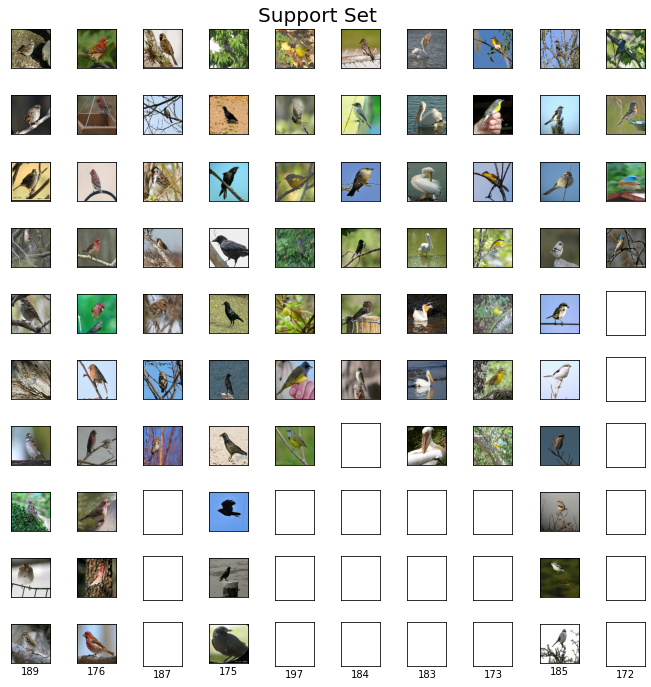

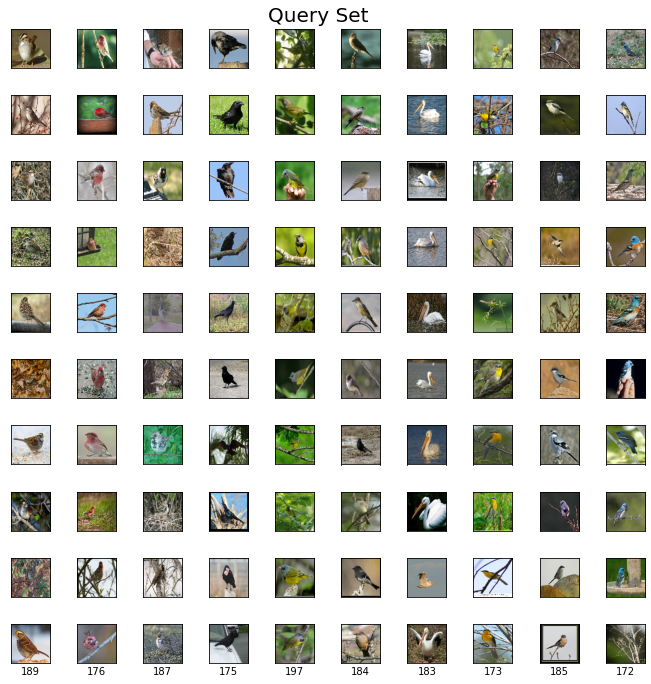

Episode id: 1 from source aircraft
#Classes: 9


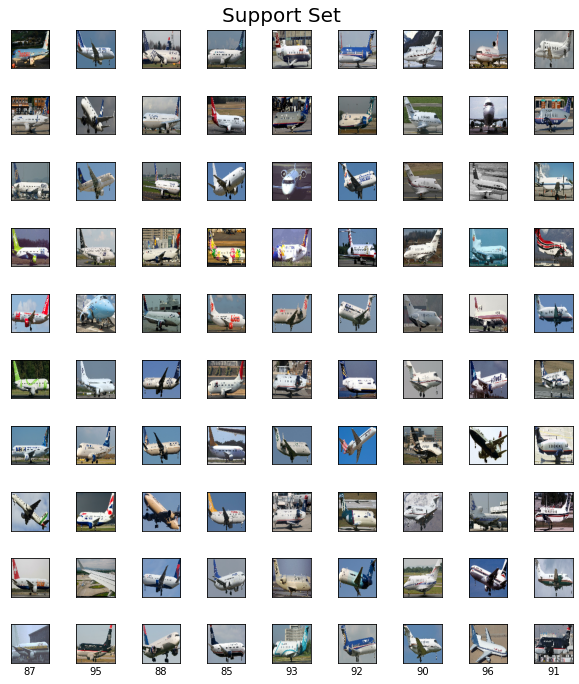

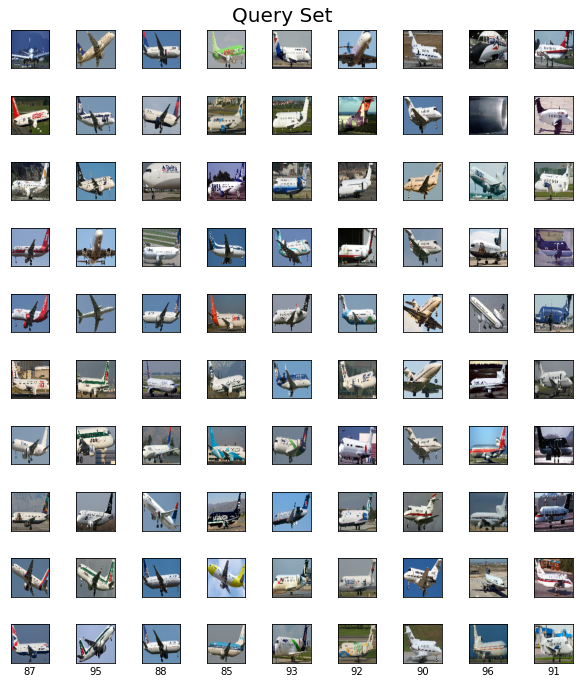

In [ ]:
# 1
N_EPISODES = 2
# 2, 3
for idx, (episode, source_id) in iterate_dataset(dataset_episodic, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, all_dataset_specs[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (2) Batch Mode
Second mode that `meta_dataset` library provides is the batch mode, where one can sample batches from the list of  datasets in a non-episodic manner and use it to train baseline models. There are couple things to note here:

- Each batch is sampled from a different dataset.
- `ADD_DATASET_OFFSET` controls whether the class_id's returned by the iterator overlaps among different datasets or not. A dataset specific offset is added in order to make returned ids unique.
- `make_multisource_batch_pipeline()` creates a `tf.data.Dataset` object that returns datasets of the form (Batch, data source ID) where similarly to the
episodic case, the data source ID is an integer Tensor that identifies which
dataset the given batch originates from.
- `shuffle_buffer_size` controls the amount of shuffling done among examples from a given dataset (unlike for the episodic pipeline).

In [ ]:
BATCH_SIZE = 16
ADD_DATASET_OFFSET = True

In [ ]:
# quickdraw_spec = [all_dataset_specs[0]]
# all_dataset_specs
dataset_batch = pipeline.make_multisource_batch_pipeline(
    dataset_spec_list=all_dataset_specs, batch_size=BATCH_SIZE, split=SPLIT,
    image_size=84, add_dataset_offset=ADD_DATASET_OFFSET,
    shuffle_buffer_size=0
    )

for idx, ((images, labels), source_id) in iterate_dataset(dataset_batch, 1):
  print(images.shape, labels.shape)

(16, 84, 84, 3) (16,)


Batch-0 from source fungi


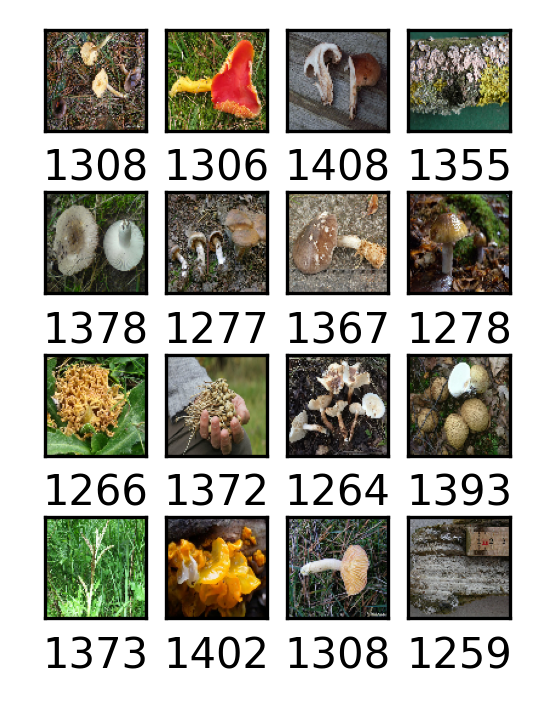

In [ ]:
N_BATCH = 1
# dataset_batch = pipeline.make_multisource_batch_pipeline(
#     dataset_spec_list=quickdraw_spec, batch_size=BATCH_SIZE, split=SPLIT,
#     image_size=84, add_dataset_offset=ADD_DATASET_OFFSET,
#     shuffle_buffer_size=0
#     )
for idx, (batch, source_id) in iterate_dataset(dataset_batch, N_BATCH):
  print('Batch-%d from source %s' % (idx, all_dataset_specs[source_id].name))
  plot_batch(*map(lambda a: a.numpy(), batch), size_multiplier=0.5)

Batch-0 from source aircraft


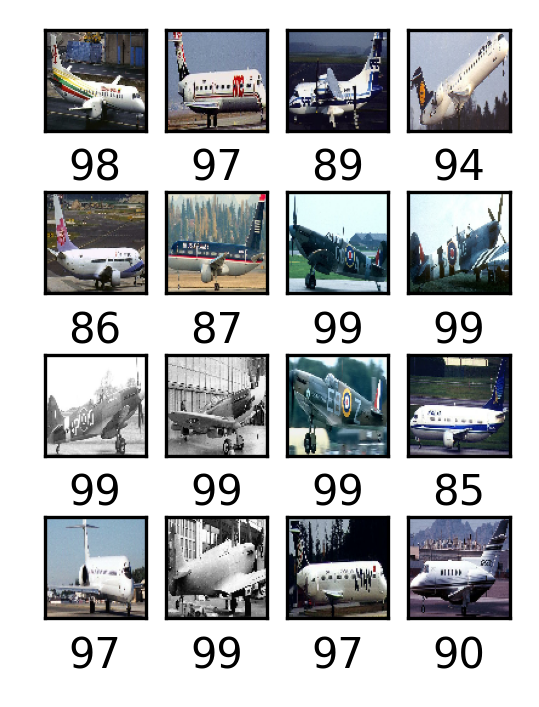

In [ ]:
N_BATCH = 1
one_dataset_batch = pipeline.make_one_source_batch_pipeline(
    dataset_spec=all_dataset_specs[0], batch_size=BATCH_SIZE, split=SPLIT,
    image_size=84, 
    shuffle_buffer_size=None
    )
for idx, (batch, source_id) in iterate_dataset(one_dataset_batch, N_BATCH):
  print('Batch-%d from source %s' % (idx, all_dataset_specs[source_id].name))
  plot_batch(*map(lambda a: a.numpy(), batch), size_multiplier=0.5)

# (3) Fixing Ways and Shots
1. `meta_dataset` library provides option to set number of classes/samples per episode. There are 3 main flags you can set. 
    - **NUM_WAYS**: Fixes the # classes per episode. We would still get variable number of samples per class in the support set.
    - **NUM_SUPPORT**: Fixes # samples per class in the support set.
    - **NUM_SUPPORT**: Fixes # samples per class in the query set.
2. If we want to use fixed `num_ways`, we have to disable ontology based sampling for omniglot and imagenet. We advise using single dataset for using this feature, since using multiple datasets is not supported/tested. In this notebook, we are using Quick, Draw! Dataset.
3. We sample episodes and visualize them as we did earlier.

Episode id: 0 from source aircraft
#Classes: 5


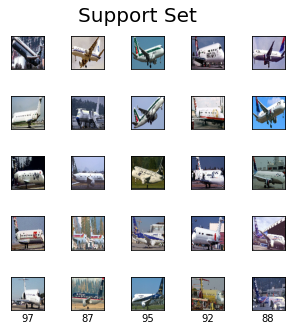

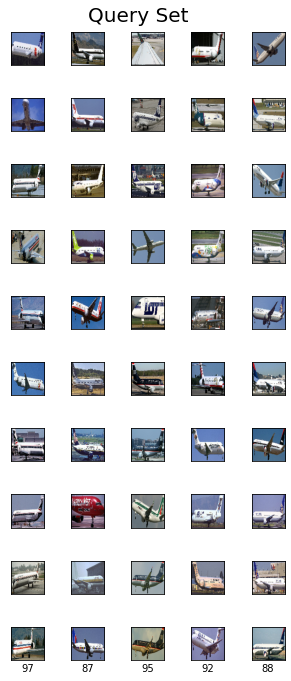

Episode id: 1 from source aircraft
#Classes: 5


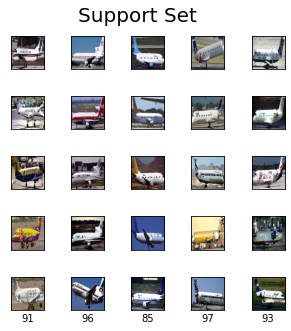

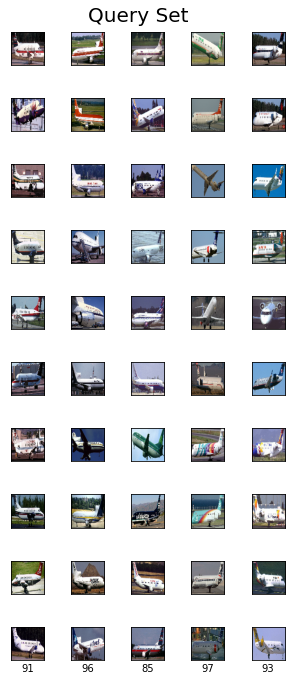

In [ ]:
#1
NUM_WAYS = 5 #5 #8
NUM_SUPPORT = 5 #5 #8
NUM_QUERY = None #15 #5
fixed_ways_shots = config.EpisodeDescriptionConfig(
    num_ways=NUM_WAYS, num_support=NUM_SUPPORT, num_query=NUM_QUERY)

#2
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
quickdraw_spec = [all_dataset_specs[0]] # init specs[6]

#3
dataset_fixed = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=quickdraw_spec, 
    use_dag_ontology_list=[False],
    use_bilevel_ontology_list=use_bilevel_ontology_list, split=SPLIT,
    image_size=84, episode_descr_config=fixed_ways_shots)

N_EPISODES = 2
for idx, (episode, source_id) in iterate_dataset(dataset_fixed, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, quickdraw_spec[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (4) Using Meta-dataset with PyTorch
As mentioned above it is super easy to consume `meta_dataset` as NumPy arrays. This also enables easy integration into other popular deep learning frameworks like PyTorch. TensorFlow code processes the data and passes it to PyTorch, ready to be consumed. Since the data loader and processing steps do not have any operation on the GPU, TF should not attempt to grab the GPU, and it should be available for PyTorch.
1. Let's use an episodic dataset created earlier, `dataset_episodic`, and build on top of it. We will transpose tensor to CHW, which is the common order used by [convolutional layers](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.functional.conv2d) of PyTorch. 
2. We will use zero-indexed labels, therefore grabbing `e[1]` and `e[4]`. At the end we return a generator that consumes the `tf.Dataset`. 
3. Using `.cuda()` on PyTorch tensors should distribute them to appropriate devices.


In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
else : 
    device = "cpu"

In [ ]:
import torch
# 1
to_torch_labels = lambda a: torch.from_numpy(a.numpy()).long()
to_torch_imgs = lambda a: torch.from_numpy(np.transpose(a.numpy(), (0, 3, 1, 2)))
# 2
def data_loader(n_batches):
  for i, (e, _) in enumerate(dataset_episodic):
    # print(_)
    if i == n_batches:
      break
    yield (to_torch_imgs(e[0]), to_torch_labels(e[1]),
           to_torch_imgs(e[3]), to_torch_labels(e[4]))

for i, batch in enumerate(data_loader(n_batches=3)):
  #3
  data_support, labels_support, data_query, labels_query = [x.to(device) for x in batch]
  print(data_support.shape, labels_support.shape, data_query.shape, labels_query.shape) 

torch.Size([247, 3, 84, 84]) torch.Size([247]) torch.Size([140, 3, 84, 84]) torch.Size([140])
torch.Size([87, 3, 84, 84]) torch.Size([87]) torch.Size([120, 3, 84, 84]) torch.Size([120])
torch.Size([12, 3, 84, 84]) torch.Size([12]) torch.Size([120, 3, 84, 84]) torch.Size([120])


<h1>Add Pretrained Model </h1>


In [ ]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
import torch
# import torch.nn as nn 
from torchvision import datasets, transforms
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.models import resnet18, resnet50, resnet152, resnet101, resnet34
from torchvision import models
from tqdm import tqdm
# from torch import nn, optim

from copy import deepcopy
import torch.nn as nn
import torch.jit
import torch.optim as optim
from torch.nn import functional as F

In [ ]:
device

'cuda:0'

In [ ]:
#1

NUM_SUPPORT = 10 #5 #8 # same as the number of shot 
NUM_WAYS = 5 #5 #8 #8 don't work with fungi
NUM_QUERY = 10 #5 #5

#2
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
fixed_ways_shots = config.EpisodeDescriptionConfig(num_ways=NUM_WAYS, num_support=NUM_SUPPORT, num_query=NUM_QUERY, )

# specific_spec = [all_dataset_specs[0]] # aircraft
# specific_spec = [all_dataset_specs[1]] # birds
# specific_spec = [all_dataset_specs[5]] # flowers
specific_spec = [all_dataset_specs[4]] # omniglot
# specific_spec = [all_dataset_specs[2]] # dtd
# specific_spec = [all_dataset_specs[3]] # fungi

#3
dataset_fixed = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=specific_spec, 
    use_dag_ontology_list=[False],
    use_bilevel_ontology_list=use_bilevel_ontology_list, 
    split=SPLIT,
    image_size=160, 
    episode_descr_config=fixed_ways_shots,
    shuffle_buffer_size=None,
)

In [ ]:
def load_data(episodic_dataset, n_batches):
  for i, (e, _) in enumerate(episodic_dataset):
    if i == n_batches:
      break
    yield (to_torch_imgs(e[0]), to_torch_labels(e[1]), to_torch_labels(e[2]),
           to_torch_imgs(e[3]), to_torch_labels(e[4]), to_torch_labels(e[5]))

Episode id: 0 from source omniglot
tf.Tensor(0, shape=(), dtype=int32)
#Classes: 5


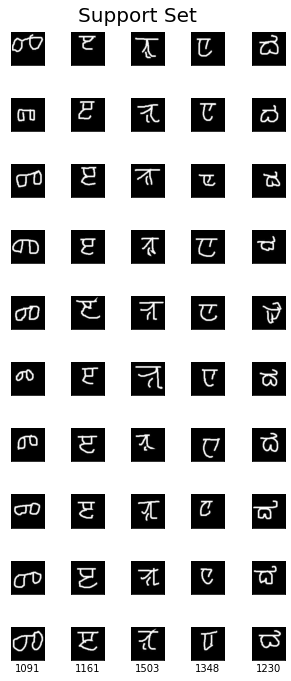

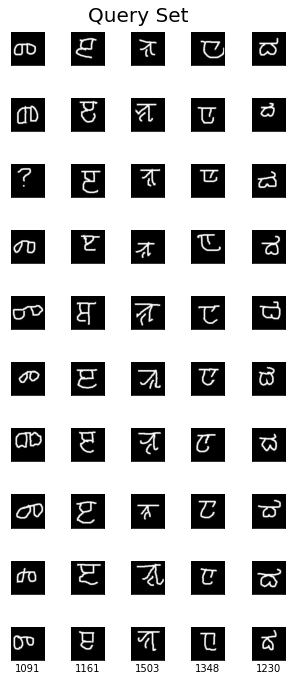

In [ ]:

N_EPISODES = 1
for idx, (episode, source_id) in iterate_dataset(dataset_fixed, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, specific_spec[source_id].name))
  print(source_id)
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

#update the last layer of this models and train again with the support set of the test task,
# in order to have a new model. and passe this model to tent.

In [ ]:
from copy import deepcopy

import torch
import torch.nn as nn


class Norm(nn.Module):
    """Norm adapts a model by estimating feature statistics during testing.

    Once equipped with Norm, the model normalizes its features during testing
    with batch-wise statistics, just like batch norm does during training.
    """

    def __init__(self, model, eps=1e-5, momentum=0.1,
                 reset_stats=False, no_stats=False):
        super().__init__()
        self.model = model
        self.model = configure_model_norm(model, eps, momentum, reset_stats,
                                     no_stats)
        self.model_state = deepcopy(self.model.state_dict())

    def forward(self, x):
        return self.model(x)

    def reset(self):
        self.model.load_state_dict(self.model_state, strict=True)


def collect_stats(model):
    """Collect the normalization stats from batch norms.

    Walk the model's modules and collect all batch normalization stats.
    Return the stats and their names.
    """
    stats = []
    names = []
    for nm, m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            state = m.state_dict()
            if m.affine:
                del state['weight'], state['bias']
            for ns, s in state.items():
                stats.append(s)
                names.append(f"{nm}.{ns}")
    return stats, names


def configure_model_norm(model, eps, momentum, reset_stats, no_stats):
    """Configure model for adaptation by test-time normalization."""
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            # use batch-wise statistics in forward
            m.train()
            # configure epsilon for stability, and momentum for updates
            m.eps = eps
            m.momentum = momentum
            if reset_stats:
                # reset state to estimate test stats without train stats
                m.reset_running_stats()
            if no_stats:
                # disable state entirely and use only batch stats
                m.track_running_stats = False
                m.running_mean = None
                m.running_var = None
    return model


In [ ]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.jit


class Tent(nn.Module):
    """Tent adapts a model by entropy minimization during testing.

    Once tented, a model adapts itself by updating on every forward.
    """
    def __init__(self, model, optimizer, steps=1, episodic=False):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.steps = steps
        assert steps > 0, "tent requires >= 1 step(s) to forward and update"
        self.episodic = episodic

        # note: if the model is never reset, like for continual adaptation,
        # then skipping the state copy would save memory
        self.model_state, self.optimizer_state = \
            copy_model_and_optimizer(self.model, self.optimizer)

    def forward(self, x):
        if self.episodic:
            self.reset()

        for _ in range(self.steps):
            outputs, loss = forward_and_adapt(x, self.model, self.optimizer)

        return outputs, loss

    def infer(self, x):
        outputs = self.model(x)
        return outputs

    def reset(self):
        if self.model_state is None or self.optimizer_state is None:
            raise Exception("cannot reset without saved model/optimizer state")
        load_model_and_optimizer(self.model, self.optimizer,
                                 self.model_state, self.optimizer_state)


@torch.jit.script
def softmax_entropy(x: torch.Tensor) -> torch.Tensor:
    """Entropy of softmax distribution from logits."""
    return -(x.softmax(1) * x.log_softmax(1)).sum(1)


@torch.enable_grad()  # ensure grads in possible no grad context for testing
def forward_and_adapt(x, model, optimizer):
    """Forward and adapt model on batch of data.

    Measure entropy of the model prediction, take gradients, and update params.
    """
    # forward
    outputs = model(x)
    # adapt
    loss = softmax_entropy(outputs).mean(0)
    loss.backward()
    # loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    return outputs, loss


def collect_params(model):
    """Collect the affine scale + shift parameters from batch norms.

    Walk the model's modules and collect all batch normalization parameters.
    Return the parameters and their names.

    Note: other choices of parameterization are possible!
    """
    params = []
    names = []
    for nm, m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            for np, p in m.named_parameters():
                if np in ['weight', 'bias']:  # weight is scale, bias is shift
                    params.append(p)
                    names.append(f"{nm}.{np}")
    return params, names


def copy_model_and_optimizer(model, optimizer):
    """Copy the model and optimizer states for resetting after adaptation."""
    model_state = deepcopy(model.state_dict())
    optimizer_state = deepcopy(optimizer.state_dict())
    return model_state, optimizer_state


def load_model_and_optimizer(model, optimizer, model_state, optimizer_state):
    """Restore the model and optimizer states from copies."""
    model.load_state_dict(model_state, strict=True)
    optimizer.load_state_dict(optimizer_state)


def configure_model(model):
    """Configure model for use with tent."""
    # train mode, because tent optimizes the model to minimize entropy
    model.train()
    # disable grad, to (re-)enable only what tent updates
    model.requires_grad_(False)
    # configure norm for tent updates: enable grad + force batch statisics
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.requires_grad_(True)
            # force use of batch stats in train and eval modes
            m.track_running_stats = False
            m.running_mean = None
            m.running_var = None
    return model


def check_model(model):
    """Check model for compatability with tent."""
    is_training = model.training
    assert is_training, "tent needs train mode: call model.train()"
    param_grads = [p.requires_grad for p in model.parameters()]
    has_any_params = any(param_grads)
    has_all_params = all(param_grads)
    assert has_any_params, "tent needs params to update: " \
                           "check which require grad"
    assert not has_all_params, "tent should not update all params: " \
                               "check which require grad"
    has_bn = any([isinstance(m, nn.BatchNorm2d) for m in model.modules()])
    assert has_bn, "tent needs normalization for its optimization"


In [ ]:

def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    return model


def setup_norm(model):
    """Set up test-time normalization adaptation.
    Adapt by normalizing features with test batch statistics.
    The statistics are measured independently for each batch;
    no running average or other cross-batch estimation is used.
    """
    norm_model = Norm(model)
    stats, stat_names = collect_stats(model)
    return norm_model


def setup_tent(model, lr=0.1):
    """Set up tent adaptation.
    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    # STEPS = 1
    STEPS = 1
    EPISODIC = False
    # EPISODIC = True
    model = configure_model(model)
    params, param_names = collect_params(model)
    optimizer = setup_optimizer(params, lr)
    tent_model = Tent(model, optimizer,
                           steps=STEPS,
                           episodic=EPISODIC)
    return tent_model


def setup_optimizer(params, lr):
    """Set up optimizer for tent adaptation.
    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.
    For best results, try tuning the learning rate and batch size.
    """
    METHOD = "SGD"
    # LR =  0.01
    LR = lr
    BETA = 0.9
    WD = 0.0
    MOMENTUM = 0.9
    DAMPENING = 0.0
    NESTEROV = True
    if METHOD == 'Adam':
        return optim.Adam(params,
                    lr=LR,
                    betas=(BETA, 0.999),
                    weight_decay=WD)
    elif METHOD == 'SGD':
        return optim.SGD(params,
                   lr=LR,
                   momentum=MOMENTUM,
                   dampening=DAMPENING,
                   weight_decay=WD,
                   nesterov=NESTEROV)
    else:
        raise NotImplementedError


In [ ]:
# import math 

class MyLinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out, support_images, support_labels):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        # weights = torch.Tensor(size_out, size_in)
        bias = torch.Tensor(size_out)

        # self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        self.bias = nn.Parameter(bias)
        self.support_images = support_images
        self.support_labels = support_labels
        self.embed_support = False
        self.prototypes = None
        self.weight = nn.Parameter(torch.zeros_like(torch.empty(size_out, size_in)))

    def forward(self, x):
        if not self.embed_support:
            # self.prototypes = x
            x = x.detach()
            weight = torch.cat(
                [
                    x[torch.nonzero(self.support_labels == label)].mean(0)
                    for label in range(self.size_out)
                ]
            )
            bias = - torch.square(torch.norm(weight, dim=1))
            self.bias = nn.Parameter(bias)
            self.weight = nn.Parameter(weight)
            self.embed_support = True

        w_times_x = 2 * torch.mm(x, self.weight.t())
        out = torch.add(w_times_x, self.bias)  # w times x + b
        return out

In [ ]:
class MyLinearLayer2(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out, support_labels, C, bias):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        self.bias = nn.Parameter(bias)
        self.support_images = support_images
        self.support_labels = support_labels
        self.weight = nn.Parameter(C)

    def forward(self, x):
        w_times_x = 2 * torch.mm(x, self.weight.t())
        out = torch.add(w_times_x, self.bias)  # w times x + b
        return out

In [ ]:
def train_episode(model, episode, in_features, num_step_fc=100, num_step_tent=100): # add an episode as a parameter
    model.to(device)
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]

    model.fc = nn.Identity()
    embed_x = model(support_images)
    C = torch.cat(
        [
            embed_x[torch.nonzero(support_labels == label)].mean(0)
            for label in range(NUM_WAYS)
        ]
    )
    bias = - torch.square(torch.norm(C, dim=1))
    model.fc = MyLinearLayer2(in_features, NUM_WAYS, support_labels, C.detach(),  bias.detach())

    # model(support_images)
    # model.eval()

    out1 = model(query_images)
    pred1 = out1.argmax(dim=1, keepdim=True)
    correct1 = pred1.cpu().eq(query_labels.detach().cpu().view_as(pred1)).sum().item()

    # at the end get the query accuracy or support accuracy and compare to the accuracy after tent to see if tent is helpful .
    # call this function 

    # print the entropy as a sanety check, it should decrease.
    # print the parameter of tent, 
    new_model = deepcopy(model)
    tented_model = setup_tent(new_model)
    tented_model.to(device)
    entropys = []

    support_batches = torch.split(support_images, 10)
    support_batches_labels = torch.split(support_labels, 10)

    for i in range(num_step_tent):
        entropy = []
        for batch in support_batches:
            out, ent = tented_model(batch) # change to support images # now it infers and adapts!
            entropy.append(ent.cpu().detach().numpy())

        entropy = np.array(entropy)
        entropys.append(np.mean(entropy))


    outputs = tented_model.infer(query_images)
    # do only inference on query set, 
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.cpu().eq(query_labels.detach().cpu().view_as(pred)).sum().item()

    total_predictions = len(query_labels)
    percent1 = 100.0 * correct1 / total_predictions
    percent = 100.0 * correct / total_predictions
    # print(f"Tent Accuracy: {correct} / {total_predictions} ({percent:.0f}%), Pretrained : {correct1} / {total_predictions} ({percent1:.0f})%")

    return percent1, percent 


In [ ]:
def train_episode_v2(model, lr, episode, in_features, num_step_tent=100): # add an episode as a parameter
    
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]

    model.to(device)
    model.fc = MyLinearLayer(in_features, NUM_WAYS, support_images, support_labels)
    model(support_images)

    out1 = model(query_images)
    pred1 = out1.argmax(dim=1, keepdim=True)
    correct1 = pred1.cpu().eq(query_labels.detach().cpu().view_as(pred1)).sum().item()
    

    # at the end get the query accuracy or support accuracy and compare to the accuracy after tent to see if tent is helpful .
    # call this function 

    # print the entropy as a sanety check, it should decrease.
    # print the parameter of tent, 
    new_model = deepcopy(model)
    tented_model = setup_tent(new_model, lr)
    tented_model.to(device)
    entropys = []

    support_batches = torch.split(support_images, 10)
    support_batches_labels = torch.split(support_labels, 10)

    for i in range(num_step_tent):
        # entropy = np.array([])
        # entropy = []
        # for batch in support_batches:
        #     out, ent = tented_model(batch) # change to support images # now it infers and adapts!
        #     entropy.append(ent.cpu().detach().numpy())

        # entropy = np.array(entropy)
        # entropys.append(np.mean(entropy))
        tented_model(support_images)

    # outputs = new_model(query_images)
    outputs = tented_model.infer(query_images)
    # do only inference on query set, 
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.cpu().eq(query_labels.detach().cpu().view_as(pred)).sum().item()

    total_predictions = len(query_labels)
    percent1 = 100.0 * correct1 / total_predictions
    percent = 100.0 * correct / total_predictions
    # print(f"Tent Accuracy: {correct} / {total_predictions} ({percent:.0f}%), Pretrained : {correct1} / {total_predictions} ({percent1:.0f})%")

    return percent1, percent 



In [ ]:
def evaluate_on_one_task(
    model,
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [ ]:
import gc
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if device == 'cuda':
  torch.cuda.empty_cache()
  gc.collect()



In [ ]:
EPISODES = 5

pretrained = resnet18(pretrained=True)

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
# convolutional_network.fc = nn.Identity()
proto_model = PrototypicalNetworks(convolutional_network).to(device)

# print('after')
pretrained.to(device)
in_features = pretrained.fc.in_features
print('last layer input size', in_features)

proto_acc = []
pretrained_acc = []
copied_model = []
LR = 1

for i, episode in tqdm(enumerate(load_data(dataset_fixed, n_batches=EPISODES)), total=EPISODES):
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]
    # print(support_images.shape, query_images.shape)
    pretrained.fc = nn.Identity()
    embed_x = pretrained(support_images)
    C = torch.cat(
        [
            embed_x[torch.nonzero(support_labels == label)].mean(0)
            for label in range(NUM_WAYS)
        ]
    )
    bias = - torch.square(torch.norm(C, dim=1))
    pretrained.fc = MyLinearLayer2(in_features, NUM_WAYS, support_labels, C.detach(),  bias.detach())
    out1 = pretrained(query_images)
    pred1 = out1.argmax(dim=1, keepdim=True)
    correct1 = pred1.cpu().eq(query_labels.detach().cpu().view_as(pred1)).sum().item()

    correct, total = evaluate_on_one_task(
        proto_model, support_images, support_labels, query_images, query_labels
    )
    percent = 100.0 * correct / total
    percent1 = 100.0 * correct1 / total

    print(percent, 'proto')
    print(percent1, 'pretrained')
    proto_acc.append(percent)
    pretrained_acc.append(percent1)

print('*'*20)
print(np.array(proto_acc).mean(), "Mean of Proto Model")
print(np.array(pretrained_acc).mean(), "Mean of the Pretrained Model")
# print(np.array(copied_model).mean(), "Mean of the Copied Model")
print('*'*20)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

last layer input size 512


 20%|██        | 1/5 [00:09<00:38,  9.69s/it]

94.0 proto
94.0 pretrained


 40%|████      | 2/5 [00:09<00:12,  4.16s/it]

92.0 proto
92.0 pretrained


 80%|████████  | 4/5 [00:10<00:01,  1.51s/it]

90.0 proto
90.0 pretrained
84.0 proto
84.0 pretrained


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]

86.0 proto
86.0 pretrained
********************
89.2 Mean of Proto Model
89.2 Mean of the Pretrained Model
********************


In [ ]:
def torch_compute_confidence_interval(data, confidence=0.95):
    """
    Computes the confidence interval for a given survey of a data set.
    """
    n = len(data)
    mean = data.mean()
    se = data.std() / (n**0.5)
    t_p  = 1.960
    ci = t_p * se
    return mean, ci

In [ ]:
# convolutional_network = resnet50()
convolutional_network = resnet18(pretrained=True)
# convolutional_network.fc = nn.Flatten()
convolutional_network.fc = nn.Identity()
model = PrototypicalNetworks(convolutional_network).to(device)


EPISODES = 200
# pretrained_model = resnet50()
pretrained_model = resnet18(pretrained=True)
# pretrained_model = resnet34()

proto_acc = []
pretrained_acc = []
tent_acc = []

LR = 0.0001
num_step_tent = 10
in_features = pretrained_model.fc.in_features

all_tent_step = [0, 10, 25, 50, 100, 200]
results = {}
for step in all_tent_step : 
    results[step] = {"tent" : [], "pretrained" : []}

for i, episode in tqdm(enumerate(load_data(dataset_fixed, n_batches=EPISODES)), total=EPISODES):
    for step in all_tent_step:
        percent_pretrained, percent_tent = train_episode_v2(pretrained_model, LR, episode, in_features, step)
        results[step]["tent"].append(percent_tent)
        results[step]["pretrained"].append(percent_pretrained)

    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]
    correct, total = evaluate_on_one_task(
        model, support_images, support_labels, query_images, query_labels
    )
    percent = 100.0 * correct / total

    # save 
    proto_acc.append(percent)
    # pretrained_acc.append(percent_pretrained)
    # tent_acc.append(percent_tent)


print('recap ---------')
print('*'*20)

proto_array = np.array(proto_acc)
mean_proto, ci_proto = torch_compute_confidence_interval(proto_array)

print(mean_proto,"±" , ci_proto, "Mean of Proto Model", "learning rate", LR)
print('*'*15)
print("Learning Rate", LR)

for step in all_tent_step:
    print('*'*10)
    print("Number of step for TENT", step)

    tent_array = np.array(results[step]["tent"])
    pretrained_array = np.array(results[step]["pretrained"])

    mean_tent, ci_tent = torch_compute_confidence_interval(tent_array)
    mean_pretrained, ci_pretrained = torch_compute_confidence_interval(pretrained_array)

    print(mean_tent, "±", ci_tent, "Mean of TENT Model")
    print(mean_pretrained, "±", ci_pretrained, "Mean of the Pretrained Model")
    print('*'*10)


 88%|████████▊ | 175/200 [1:30:16<12:52, 30.90s/it]

Play with the number of shot, dataset, 

In [ ]:
# Bird
# ********************
# 52.68571428571428 Mean of TENT Model
# 72.54285714285714 Mean of Proto Model
# 73.3 Mean of the Pretrained Model
# ********************

# Flower
# ********************
# 72.30000000000001 Mean of TENT Model
# 84.9857142857143 Mean of Proto Model
# 85.54285714285714 Mean of the Pretrained Model
# ********************

Without tent, just check the result 

In [ ]:
# convolutional_network = resnet50()
convolutional_network = resnet18(pretrained=True)
# convolutional_network.fc = nn.Flatten()
convolutional_network.fc = nn.Identity()
model = PrototypicalNetworks(convolutional_network).to(device)

EPISODES = 10
# pretrained_model = resnet50()
pretrained_model = resnet18(pretrained=True)
# pretrained_model = resnet34()

proto_acc = []
pretrained_acc = []
tent_acc = []

LR = 0.01
num_step_tent = 10
in_features = pretrained_model.fc.in_features

all_tent_step = [0, 10, 25, 50, 100, 200]
results = {}
for step in all_tent_step : 
    results[step] = {"tent" : [], "pretrained" : []}

# print(results)
for i, episode in tqdm(enumerate(load_data(dataset_fixed, n_batches=EPISODES)), total=EPISODES):
    
    percent_pretrained, percent_tent = train_episode_v2(pretrained_model, LR, episode, in_features, num_step_tent)
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]
    correct, total = evaluate_on_one_task(
        model, support_images, support_labels, query_images, query_labels
    )
    percent = 100.0 * correct / total

    # save 
    proto_acc.append(percent)
    pretrained_acc.append(percent_pretrained)
    tent_acc.append(percent_tent)

    # display
    # print(f"Proto Accuracy: {correct} / {total} ({percent:.0f}%)")
    # print('-'*20)
    # print('-'*20)


print('recap ---------')
print('*'*20)

tent_array = np.array(tent_acc)
proto_array = np.array(pretrained_acc)
pretrained_array = np.array(proto_acc)

mean_tent, ci_tent = torch_compute_confidence_interval(tent_array)
mean_proto, ci_proto = torch_compute_confidence_interval(proto_array)
mean_pretrained, ci_pretrained = torch_compute_confidence_interval(pretrained_array)


print('*'*20)
print(mean_tent,"±" ,ci_tent, "Mean of TENT Model")
print(mean_proto, ci_proto, "Mean of Proto Model")
print(mean_pretrained, ci_pretrained, "Mean of the Pretrained Model")
print('*'*20)


train on another pretrained models (image models, coco, )
create a table for every dataset,

evaluate the models on each dataset (same evaluation on each dataset by using meta training models)

write a google doc with all the result table ( 2 table )

number of episode per dataset 600, 

try to use tent.


Next step: 

run tent on one dataset aircraft(image net), and read the paper, not meta training. 


